In [1]:
import os
import numpy as np
import pandas as pd
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import *
import matplotlib.pyplot as plt
% %matplotlib inline
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.decomposition import PCA
import string

ModuleNotFoundError: No module named 'numpy'

# merge separate tables into one dataframe

In [3]:
team_key = {
    'Chicago Cubs':'CHC',
    'St. Louis Cardinals':'STL',
    'Colorado Rockies': 'COL',
    'Washington Nationals': 'WSN',
    'Minnesota Twins': 'MIN',
    'San Francisco Giants': 'SFG',
    'Boston Red Sox': 'BOS',
    'Toronto Blue Jays': 'TOR',
    'New York Yankees': 'NYY',
    'Seattle Mariners': 'SEA',
    'Atlanta Braves': 'ATL',
    'Baltimore Orioles': 'BAL',
    'Milwaukee Brewers': 'MIL',
    'Philadelphia Phillies': 'PHI',
    'Arizona Diamondbacks': 'ARI',
    'Chicago White Sox': 'CHW',
    'Cincinnati Reds': 'CIN',
    'San Diego Padres':'SDP',
    'Texas Rangers': 'TEX',
    'Los Angeles Angels': 'LAA',
    'Oakland Athletics':'OAK',
    'Tampa Bay Rays': 'TBR',
    'Miami Marlins': 'MIA',
    'Houston Astros': 'HOU',
    'New York Mets': 'NYM',
    'Pittsburgh Pirates': 'PIT',
    'Detroit Tigers': 'DET',
    'Cleveland Indians': 'CLE',
    'Kansas City Royals': 'KCR',
    'Los Angeles Dodgers': 'LAD',
}

In [29]:
home_teams = master_df.rename(columns={'t_home':'team',
                                      't_away': 'opp_team',
                                      'p_away': 'opp_pitcher',
                                      'p_away_LHP': 'opp_pitcher_lefty',
                                      'p_home': 'own_pitcher',
                                      'p_home_LHP':'own_pitcher_lefty' })
home_teams['home'] = True
away_teams = master_df.rename(columns={'t_away':'team',
                                      't_home': 'opp_team',
                                      'p_home': 'opp_pitcher',
                                      'p_home_LHP': 'opp_pitcher_lefty',
                                      'p_away': 'own_pitcher',
                                      'p_away_LHP':'own_pitcher_lefty' })
away_teams['home'] = False
matchups_long = pd.concat([away_teams,home_teams])

In [156]:
def load_data(filename, prefix):
    """Combine all three years of data for a file. Places prefix for each column"""
    years = ['s2014','s2015','s2016']
    mid_path = '/data/'
     
    for year in years:        
        path = year + mid_path + filename + '.csv'
        df = pd.read_csv(path,parse_dates = ['Date'], infer_datetime_format=True, index_col = 0, encoding='latin1')
        if year == 's2014':
            df_m = df
        else:
            df_m = df_m.append(df)
    
    df_m.columns = prefix + "__" + np.array(df_m.columns)
    
    return df_m



In [4]:
matchups_long = pd.read_csv('matchups_long.csv')
matchups_long['date'] = matchups_long.date.apply(pd.to_datetime)
matchups_long['date_m1'] = matchups_long.date - datetime.timedelta(days = 1)
matchups_long = matchups_long[matchups_long.team != 'National League All-Stars']
matchups_long = matchups_long[matchups_long.team != 'American League All-Stars']
matchups_long['team_fg'] = matchups_long.team.apply(lambda x: team_key[x])
matchups_long['opp_team_fg'] = matchups_long.opp_team.apply(lambda x: team_key[x])

#opp team bullpen past 7 days
temp_df = load_data('pitching/bullpen_past7_master','opp_team_bullpen_p7')
matchups_long = pd.merge(matchups_long,temp_df,
                how = 'left', 
                left_on=['date_m1', 'opp_team_fg'],
                right_on=['opp_team_bullpen_p7_|_Date','opp_team_bullpen_p7_|_Team'])

#bullpen_season_master
temp_df = load_data('pitching/bullpen_season_master','opp_team_bullpen_season')
matchups_long = pd.merge(matchups_long,temp_df,
                how = 'left', 
                left_on=['date_m1', 'opp_team_fg'],
                right_on=['opp_team_bullpen_season_|_Date','opp_team_bullpen_season_|_Team'])

#past_3games_batted_balls_master
temp_df = load_data('pitching/past_3games_batted_balls_master','opp_pitcher_battedballs_p3')
right_variables = ['opp_pitcher_battedballs_p3_|_Date','opp_pitcher_battedballs_p3_|_Team','opp_pitcher_battedballs_p3_|_Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
matchups_long = pd.merge(matchups_long,temp_df,
                how = 'left', 
                left_on=['date_m1', 'opp_team_fg','opp_pitcher'],
                right_on=right_variables)

#season_batted_balls_master
temp_df = load_data('pitching/season_batted_balls_master','opp_pitcher_battedballs_season')
right_variables = ['opp_pitcher_battedballs_season_|_Date','opp_pitcher_battedballs_season_|_Team','opp_pitcher_battedballs_season_|_Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
matchups_long = pd.merge(matchups_long,temp_df,
                how = 'left', 
                left_on=['date_m1', 'opp_team_fg','opp_pitcher'],
                right_on=right_variables)

#past_3games_master
temp_df = load_data('pitching/past_3games_master','opp_pitcher_p3')
right_variables = ['opp_pitcher_p3_|_Date','opp_pitcher_p3_|_Team','opp_pitcher_p3_|_Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
matchups_long = pd.merge(matchups_long,temp_df,
                how = 'left', 
                left_on=['date_m1', 'opp_team_fg','opp_pitcher'],
                right_on=right_variables)

#season_away_master
#season_home_master
temp_df = load_data('pitching/season_away_master','opp_pitcher_season')
right_variables = ['opp_pitcher_season_|_Date','opp_pitcher_season_|_Team','opp_pitcher_season_|_Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
temp_df['opp_pitcher_Away'] = True

temp_df2 = load_data('pitching/season_home_master','opp_pitcher_season')
right_variables = ['opp_pitcher_season_|_Date','opp_pitcher_season_|_Team','opp_pitcher_season_|_Name']
temp_df2 = temp_df2.drop_duplicates(subset=right_variables)
temp_df2['opp_pitcher_Away'] = False

temp_df = temp_df.append(temp_df2)
right_variables = ['opp_pitcher_season_|_Date','opp_pitcher_season_|_Team','opp_pitcher_season_|_Name','opp_pitcher_Away']
matchups_long = pd.merge(matchups_long,temp_df,
                how = 'left', 
                left_on=['date_m1', 'opp_team_fg','opp_pitcher','home'],
                right_on=right_variables)

#merge on labels
final_df = load_data('hitting/results_master','results')
left_variables = ['results_|_Date','results_|_Name','results_|_Team']
final_df = final_df.drop_duplicates(subset=left_variables)
left_variables = ['results_|_Date','results_|_Team']
final_df = pd.merge(final_df, matchups_long,
               how = 'left',
               left_on = left_variables,
               right_on = ['date','team_fg'])

#team_past7_master own team
temp_df = load_data('hitting/team_past7_master','team_p7')
right_variables = ['team_p7_|_Date','team_p7_|_Team']
temp_df = temp_df.drop_duplicates(subset=right_variables)
final_df = pd.merge(final_df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg'],
                right_on=right_variables)

#team_season_master - missing a chunk of data for 2016
#team_past7_master opposing team
temp_df = load_data('hitting/team_past7_master','opp_team_p7')
right_variables = ['opp_team_p7_|_Date','opp_team_p7_|_Team']
temp_df = temp_df.drop_duplicates(subset=right_variables)
final_df = pd.merge(final_df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'opp_team_fg'],
                right_on=right_variables)

#past_7_batted_balls_master
temp_df = load_data('hitting/past_7_batted_balls_master','battedballs_p7')
right_variables = ['battedballs_p7_|_Date','battedballs_p7_|_Team','battedballs_p7_|_Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
final_df = pd.merge(final_df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg','results_|_Name'],
                right_on=right_variables)

#season_batted_balls_master
temp_df = load_data('hitting/season_batted_balls_master','battedballs_season')
right_variables = ['battedballs_season_|_Date','battedballs_season_|_Team','battedballs_season_|_Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
final_df = pd.merge(final_df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg','results_|_Name'],
                right_on=right_variables)

#week_master
temp_df = load_data('hitting/week_master','p7')
right_variables = ['p7_|_Date','p7_|_Team','p7_|_Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
final_df = pd.merge(final_df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg','results_|_Name'],
                right_on=right_variables)

#season_righties_master
#season_lefties_master
temp_df = load_data('hitting/season_righties_master','hand_splits_season')
right_variables = ['hand_splits_season_|_Date','hand_splits_season_|_Team','hand_splits_season_|_Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
temp_df['hand_splits_season_|_lefty'] = False

temp_df2 = load_data('hitting/season_lefties_master','hand_splits_season')
right_variables = ['hand_splits_season_|_Date','hand_splits_season_|_Team','hand_splits_season_|_Name']
temp_df2 = temp_df2.drop_duplicates(subset=right_variables)
temp_df2['hand_splits_season_|_lefty'] = True
temp_df = temp_df.append(temp_df2)

right_variables = ['hand_splits_season_|_Date','hand_splits_season_|_Team','hand_splits_season_|_Name','hand_splits_season_|_lefty']
final_df = pd.merge(final_df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg','results_|_Name','opp_pitcher_lefty'],
                right_on=right_variables)

#season_away_master
#season_home_master
temp_df = load_data('hitting/season_away_master','ah_splits_season')
right_variables = ['ah_splits_season_|_Date','ah_splits_season_|_Team','ah_splits_season_|_Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
temp_df['ah_splits_season_|_home'] = False

temp_df2 = load_data('hitting/season_home_master','ah_splits_season')
right_variables = ['ah_splits_season_|_Date','ah_splits_season_|_Team','ah_splits_season_|_Name']
temp_df2 = temp_df2.drop_duplicates(subset=right_variables)
temp_df2['ah_splits_season_|_home'] = True
temp_df = temp_df.append(temp_df2)

right_variables = ['ah_splits_season_|_Date','ah_splits_season_|_Team','ah_splits_season_|_Name','ah_splits_season_|_home']
final_df = pd.merge(final_df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg','results_|_Name','home'],
                right_on=right_variables)

NameError: name 'load_data' is not defined

In [223]:
final_df.dropna(inplace=True)
final_df.to_csv('final_dataset_complete.csv')

# Clean dataset

In [5]:
df = pd.read_csv('final_dataset_complete.csv', index_col=0)
# pull out labels
labels = df['results_|_AVG'] > 0

#drop results columns
drop_col = [col for col in list(df) if col.startswith('results')]
df.drop(drop_col, axis = 1, inplace=True)

# drop all % signs from dataframe
for col in [col for col in list(df) if col.endswith('%')]:
    df[col] = df[col].str.replace("%","").astype(float)
for col in [col for col in list(df) if col.endswith('HR/FB')]:
    df[col] = df[col].str.replace("%","").astype(float)

# drop all boolean values from df
# these were used to merge correct splits stats, and are not useful anymore
drop_col = [col for col in list(df) if df[col].dtypes == "bool"]
df.drop(drop_col, axis = 1, inplace=True)

# create useful variable from date
df.date = pd.to_datetime(df.date)
df['weekday'] = df.date.map(lambda x: x.weekday())
df['is_weekend'] = df.weekday.map(lambda x: x >= 5)
df['week_num'] = df.date.map(lambda x: x.isocalendar()[1])
df.drop(['weekday'], axis = 1, inplace=True)

# pull out identifiers
goodies =['p7_|_Name','date','matchup','opp_pitcher','opp_team','own_pitcher','team','team_fg','opp_team_fg']
identifiers = df[goodies]

# drop object fields
drop_col = [col for col in list(df) if df[col].dtypes == "O"]
df.drop(drop_col, axis = 1, inplace=True)
df.drop(['date'], axis = 1, inplace=True)

# drop season column
drop_col = [col for col in list(df) if col.endswith('Season')]
df.drop(drop_col, axis = 1, inplace=True)

# drop leftover index columns
drop_col = [col for col in list(df) if col.endswith('#')]
df.drop(drop_col, axis = 1, inplace=True)

# Build Model

## Imports and shuffle

In [6]:
X,Y,Z = shuffle(df, labels, identifiers)
X_train, Y_train, Z_train = X[:90000], Y[:90000], Z[:90000]
X_dev, Y_dev, Z_dev = X[90000:100000], Y[90000:100000], Z[90000:100000]
X_test, Y_test, Z_test = X[100000:], Y[100000:], Z[100000:]

## Target

In [355]:
identifiers.groupby(['date']).agg('count')['p7_|_Name'].describe()

count    514.000000
mean     218.752918
std       65.617113
min        9.000000
25%      184.000000
50%      238.000000
75%      266.000000
max      366.000000
Name: p7_|_Name, dtype: float64

In [356]:
# ultimately, only care about the top 2% of batters.
5/218

0.022935779816513763

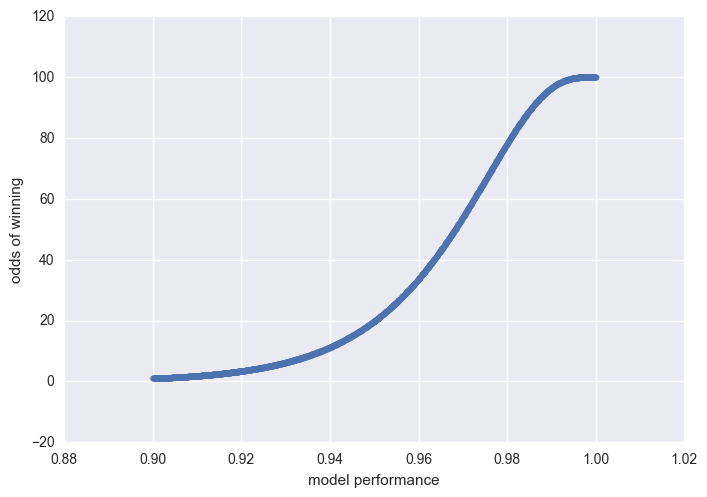

In [16]:
# need to have phenomenal prediction performance for that top 2 percent
# if pick two per day, have 4 -5 chances depending on start date (assuming all losses come late in streak)
# just a 50% chance requires a score over 97%
acc = np.linspace(.9,1,1000)
acc = pd.DataFrame(np.vstack([np.array([(1 -((1- x ** 57))**4) *100 for x in acc]),acc]).transpose(), columns=['odds of winning','model performance'])
sns.regplot(data = acc,y='odds of winning',x = 'model performance',fit_reg=False)

In [36]:
# 200ish features
len(X_dev.columns)

195

## Baseline
Picked at random, there is a 57% chance of being correct. Basline logistic regression true recall is 62%. True recall is the most important metric. Want a well-calibrated model, since we only care about the predictions of 1 - 2 observations per day, which will be those with the highest odds.

In [141]:
np.mean(Y_train)

0.57463333333333333

In [159]:
l1 = LogisticRegression()
l1.fit(X_train, Y_train)
print(classification_report(l1.predict(X_dev), Y_dev))

             precision    recall  f1-score   support

      False       0.34      0.60      0.43      2412
       True       0.83      0.63      0.72      7588

avg / total       0.71      0.62      0.65     10000



In [152]:
recall_score(l1.predict(X_dev), Y_dev)

0.624121003051612

In [379]:
probs = l1.predict_proba(X_dev)

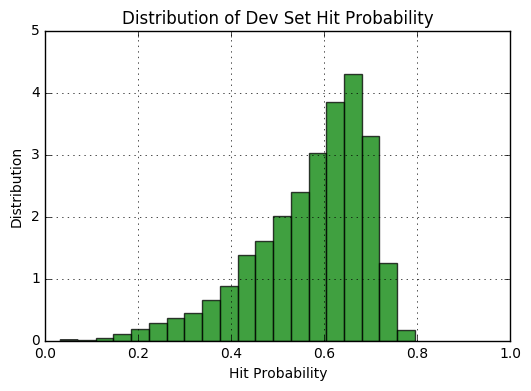

In [145]:
plt.hist(probs[:,1], 20, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Hit Probability')
plt.ylabel('Distribution')
plt.title("Distribution of Dev Set Hit Probability")
plt.axis([0, 1, 0, 5])
plt.grid(True)

plt.show()

Isolating the hitters with higher probabilities, increases recall to around 71%

In [123]:
def get_calibration(labels, model = None,df = None, tree_vote = None):
    """Return dataframe and graph of probability threshold by recall score and size (percent) of sample"""
    if model != None:
        probs = model.predict_proba(df)
        probs = probs[:,1]
    if tree_vote != None:
        probs = tree_vote
    max_prob = np.max(probs)
    max_recall = 0
    for i,threshold in enumerate(np.linspace(.5,max_prob, num = 20)):
        select = np.where(probs >= threshold)[0]
        labs = labels.reset_index(drop = True).ix[select]
        recall = np.mean(labs)
        n = len(labs)/len(probs)

        if n < .02:
            row = np.array([threshold, recall, 2, threshold,n,2]).reshape(2,3)
        else:
            row = np.array([threshold, recall, 0, threshold,n,1]).reshape(2,3)
            if recall > max_recall:
                max_recall = recall
        if i == 0:
            table = row
        else:
            table = np.vstack([table,row])    
    
    calibration_matrix = pd.DataFrame(table, columns = ["prob_thresh","value","stat"])
    print("Max recall is {}".format(max_recall))
    sns.lmplot(data = calibration_matrix, x="prob_thresh", y="value", hue = "stat", fit_reg=False )
    return calibration_matrix

Max recall is 0.7431192660550459


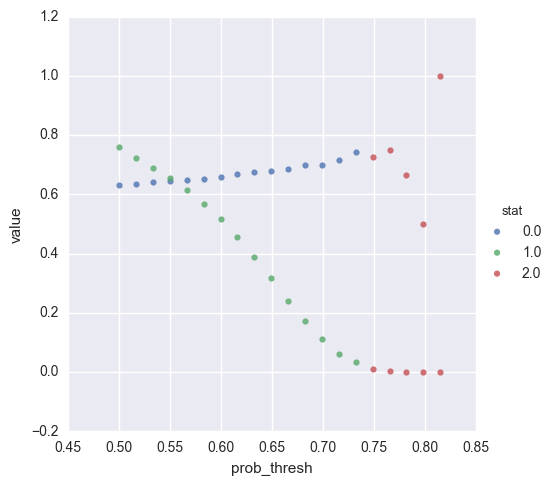

In [160]:
calibration_matrix = get_calibration(labels=Y_dev, model=l1, df = X_dev)

In [220]:
l1.predict_proba(X_train)[:,1]

array([ 0.51929936,  0.62244958,  0.71931817, ...,  0.61985904,
        0.60699168,  0.66220894])

In [234]:
X_train.reset_index().ix[test].head()

,index,opp_team_bullpen_p7_|_IP,opp_team_bullpen_p7_|_TBF,opp_team_bullpen_p7_|_K/9,opp_team_bullpen_p7_|_BB/9,opp_team_bullpen_p7_|_K/BB,opp_team_bullpen_p7_|_HR/9,opp_team_bullpen_p7_|_K%,opp_team_bullpen_p7_|_BB%,opp_team_bullpen_p7_|_K-BB%,...,ah_splits_season_|_SLG,ah_splits_season_|_OPS,ah_splits_season_|_ISO,ah_splits_season_|_BABIP,ah_splits_season_|_wRC,ah_splits_season_|_wRAA,ah_splits_season_|_wOBA,ah_splits_season_|_wRC+,is_weekend,week_num
1,44761,23.0,101.0,12.1,2.7,4.4,0.4,30.7,6.9,23.8,...,0.425,0.738,0.170,0.311,34.0,3.3,0.325,106.0,True,36
2,37171,22.1,99.0,13.7,4.8,2.8,0.0,34.3,12.1,22.2,...,0.310,0.641,0.090,0.297,23.0,-2.3,0.297,80.0,False,33
9,23349,18.2,82.0,5.8,3.9,1.5,1.0,14.6,9.8,4.9,...,0.500,0.890,0.159,0.398,23.0,8.6,0.392,154.0,True,25
10,123493,22.0,97.0,10.2,3.7,2.8,0.0,25.8,9.3,16.5,...,0.208,0.416,0.056,0.175,1.0,-8.2,0.190,17.0,False,24
11,109838,37.1,144.0,7.5,3.6,2.1,0.0,21.5,10.4,11.1,...,0.462,0.823,0.231,0.259,7.0,1.6,0.358,122.0,False,17


In [223]:
test = np.where(l1.predict_proba(X_train)[:,1] > np.percentile(l1.predict_proba(X_train)[:,1], 50))

In [282]:
def get_calibration_n(labels, model = None,df = None, tree_vote = None):
    """Return dataframe and graph of probability threshold by recall score and size relative to original sample"""
    if model != None:
        probs = model.predict_proba(df)
        probs = probs[:,1]
    if tree_vote != None:
        probs = tree_vote
    max_prob = np.max(probs)
    max_recall = 0
    cutoff = len(labels)
    for i,threshold in enumerate(np.linspace(.5,max_prob, num = 20)):
        select = np.where(probs >= threshold)[0]
        labs = labels.reset_index(drop = True).ix[select]
        recall = np.mean(labs)
        n = len(labs)/cutoff

        if n < .02:
            row = np.array([threshold, recall, 2, threshold,n,2]).reshape(2,3)
        else:
            row = np.array([threshold, recall, 0, threshold,n,1]).reshape(2,3)
            if recall > max_recall:
                max_recall = recall
        if i == 0:
            table = row
        else:
            table = np.vstack([table,row])    
    
    calibration_matrix = pd.DataFrame(table, columns = ["prob_thresh","value","stat"])
    print("Max recall is {}".format(max_recall))
    sns.lmplot(data = calibration_matrix, x="prob_thresh", y="value", hue = "stat", fit_reg=False )
    return calibration_matrix

def chain_models(model, 
                 train = X_train, 
                 train_labels = Y_train, 
                 dev = X_dev, 
                 dev_labels = Y_dev, 
                 splits =4):
    
    #train_index = range(len(train))
    #dev_index = range(len(dev))
    
    #reset indices here
    train = train.reset_index()
    train_labels = train_labels.reset_index(drop = True)
    dev = dev.reset_index()
    dev_labels = dev_labels.reset_index(drop = True)
    
    for split in range(splits):
        
        # filter data based on results of previous model
        if split > 0:
            train = train.ix[train_index]
            train = train.reset_index(drop = True)

            train_labels = train_labels.ix[train_index]
            train_labels = train_labels.reset_index(drop = True)
            
            dev = dev.ix[dev_index]
            dev = dev.reset_index(drop = True)
            
            dev_labels = dev_labels.ix[dev_index]
            dev_labels = dev_labels.reset_index(drop = True)
        
        model.fit(train, train_labels)
        print(len(model.coef_[0]))
        print(np.sum(model.predict(dev)), len(dev))
        print("-"*100)
        print("Number of splits {}. Size of train sample {}".format(split,len(train)))
        print(classification_report(model.predict(dev), dev_labels))
        temp = get_calibration_n(labels = dev_labels, model = model, df = dev)
        
        
        train_cut_point = np.percentile(model.predict_proba(train)[:,1], 50)
        train_index = np.where(model.predict_proba(train)[:,1] > train_cut_point)
        
        dev_cut_point = np.percentile(model.predict_proba(dev)[:,1], 50)
        dev_index = np.where(model.predict_proba(dev)[:,1] > dev_cut_point)    


196
7528 10000
----------------------------------------------------------------------------------------------------
Number of splits 0. Size of train sample 90000
             precision    recall  f1-score   support

      False       0.35      0.60      0.44      2472
       True       0.83      0.63      0.72      7528

avg / total       0.71      0.62      0.65     10000

Max recall is 0.7351598173515982
196
5000 5000
----------------------------------------------------------------------------------------------------
Number of splits 1. Size of train sample 45000
             precision    recall  f1-score   support

      False       0.00      0.00      0.00         0
       True       1.00      0.66      0.80      5000

avg / total       1.00      0.66      0.80      5000

Max recall is 0.7121212121212122


C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


196
2500 2500
----------------------------------------------------------------------------------------------------
Number of splits 2. Size of train sample 22500
             precision    recall  f1-score   support

      False       0.00      0.00      0.00         0
       True       1.00      0.68      0.81      2500

avg / total       1.00      0.68      0.81      2500

Max recall is 0.6796467282215978
196
1250 1250
----------------------------------------------------------------------------------------------------
Number of splits 3. Size of train sample 11250
             precision    recall  f1-score   support

      False       0.00      0.00      0.00         0
       True       1.00      0.66      0.79      1250

avg / total       1.00      0.66      0.79      1250

Max recall is 0.696969696969697


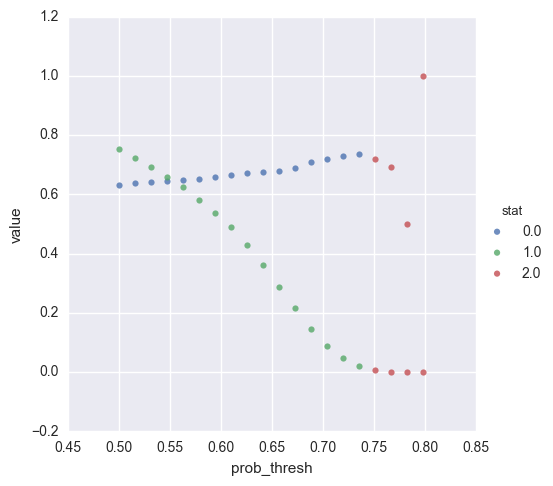

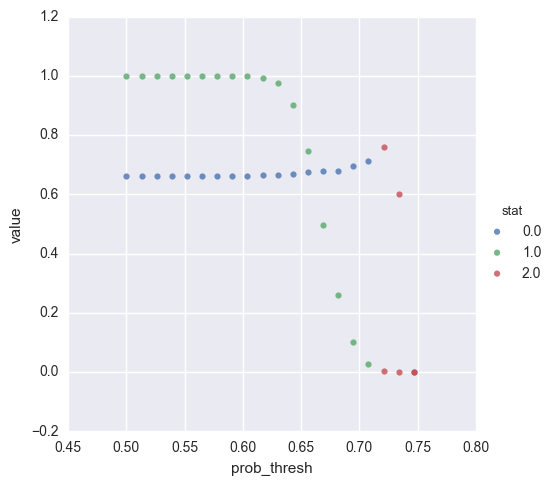

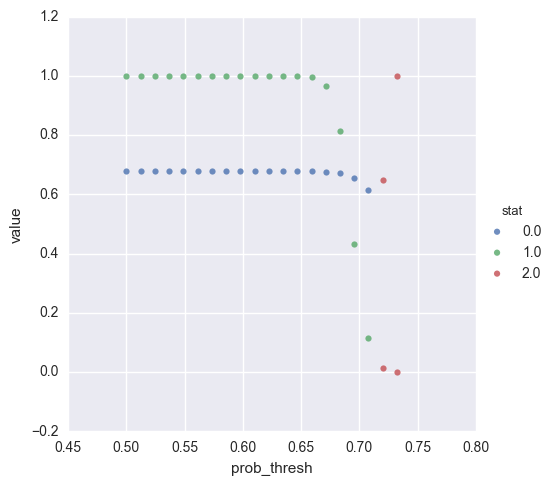

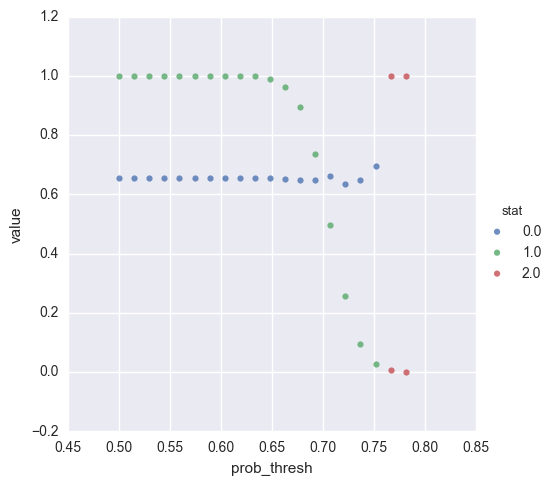

In [283]:
chain_models(model=LogisticRegression())

## PCA

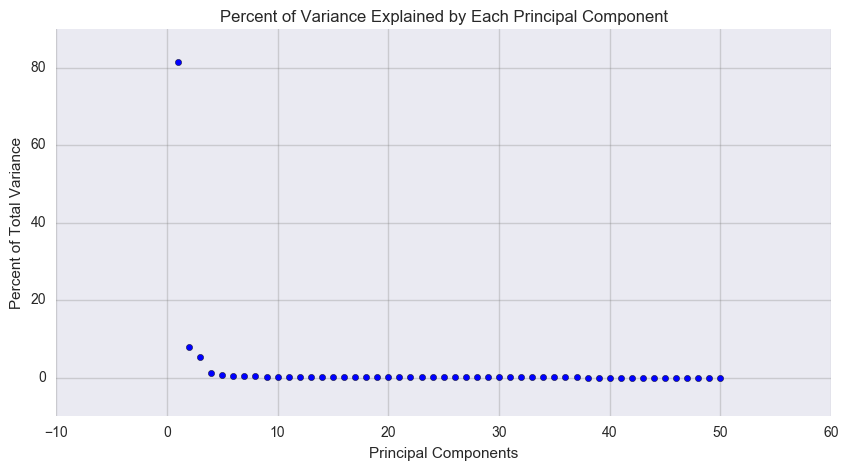

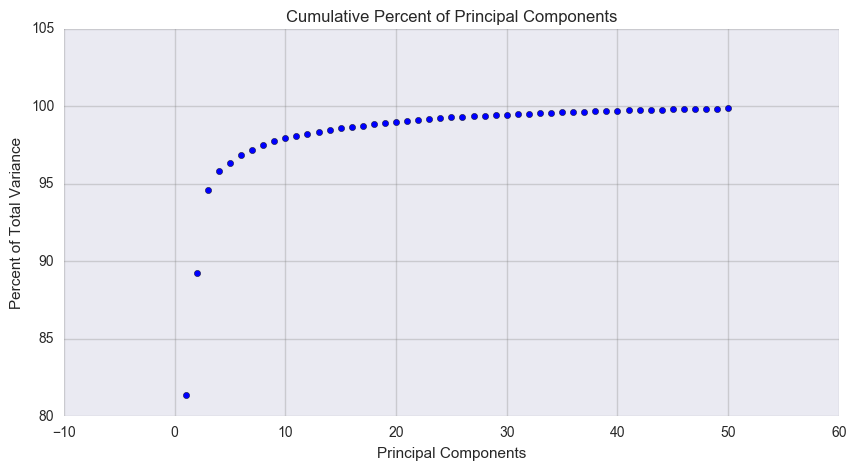

In [155]:
def P1(df = X_train, k = 50):
    
    # instantiate and fit PCA object
    # pull out variance ratio
    pca = PCA(n_components=k)
    pca.fit(df)
    expl_variance = pca.explained_variance_ratio_
    plt.rcParams['figure.figsize'] = (10.0, 5.0)
    
    # plot variance explained by each component
    plt.scatter(x=list(range(1,k+1)), y = expl_variance*100)
    plt.xlabel('Principal Components')
    plt.ylabel('Percent of Total Variance')
    plt.title('Percent of Variance Explained by Each Principal Component')
    plt.grid(b=True, which='major', color='grey', linestyle='-', alpha = .3)
    plt.show()
    
    # plot cumulative sum of variance for k components
    plt.scatter(x=list(range(1,k+1)), y = np.cumsum(expl_variance*100))
    plt.xlabel('Principal Components')
    plt.ylabel('Percent of Total Variance')
    plt.title('Cumulative Percent of Principal Components')
    plt.grid(b=True, which='major', color='grey', linestyle='-', alpha = .3)
    plt.show()    

P1()

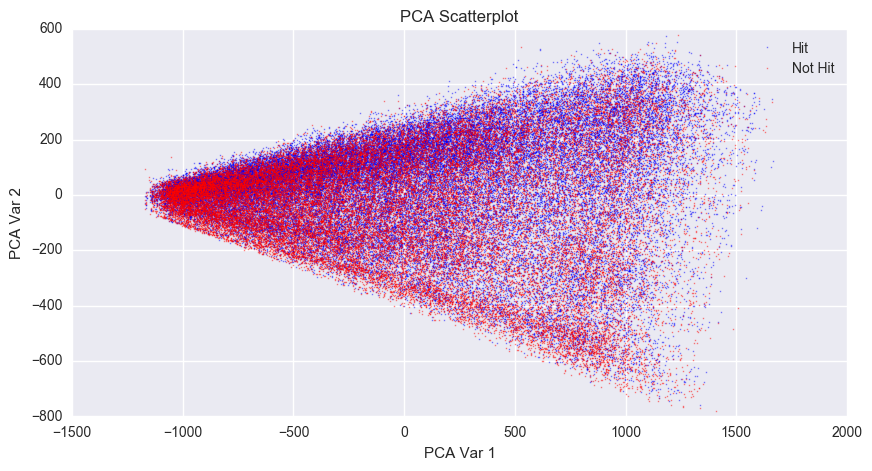

In [156]:
def P2(df = X_train, labels = Y_train):
    
    # reduce dataset and associate with labels
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(df)
    hit = transformed[np.where(labels == 1)]
    no_hit = transformed[np.where(labels == 0)]
    
    # plot the 2d reduced dataset by label
    plt.plot(hit[:,0], hit[:,1], 'bs',
            no_hit[:,0],no_hit[:,1], 'rs',
             ms = 1, alpha = .5)
    plt.xlabel('PCA Var 1')
    plt.ylabel('PCA Var 2')
    plt.title("PCA Scatterplot")
    plt.legend(['Hit','Not Hit'])    
    plt.show()
    
    

P2()

Max recall is 0.6819866567828021


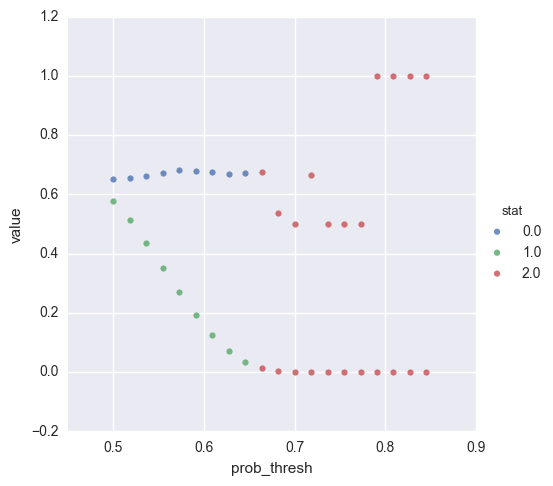

In [191]:
n = 6
pca = PCA(n_components=n)
col_names = [a for a in string.ascii_lowercase]
X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca, index=X_train.index, columns=col_names[:n])
X_dev_pca = pca.transform(X_dev)
X_dev_pca = pd.DataFrame(X_dev_pca, index=X_dev.index, columns=col_names[:n])
for col1 in X_train_pca.columns:
    for col2 in X_train_pca.columns:
        if col1+col2 in X_train_pca.columns:
            continue
        if col2+col1 in X_train_pca.columns:
            continue
        if col1 == col2:
            continue
        if len(col1) > 1 or len(col2)> 1:
            continue
        X_train_pca[col1+col2] = X_train_pca[col1] * X_train_pca[col2]
        X_dev_pca[col1+col2] = X_dev_pca[col1] * X_dev_pca[col2]
l2 = LogisticRegression()
l2.fit(X_train_pca, Y_train)
calibration_matrix = get_calibration(labels=Y_dev, model=l2, df = X_dev_pca)

In [193]:
print(classification_report(l2.predict(X_dev_pca), Y_dev))

             precision    recall  f1-score   support

      False       0.52      0.52      0.52      4234
       True       0.65      0.65      0.65      5766

avg / total       0.60      0.60      0.60     10000



## Random Forest

### Convert all numeric variables to ordinal

In [18]:
def define_groups(df, full_set = X, max_bins = 2):
    """Convert all dataframe columns to ordinal up to the number of specified bins, column permitting.
    Returns ordinal df, and cut points of training corpus (full_set)"""
    df = df.copy()
    
    # Find max number of groups each column can handle without splitting numbers between groups
    all_thresholds = {}
    for col in full_set.columns:
        # iterate max_bins down to find mutually exclusive cut points
        for b in range(max_bins+1,2,-1):
            
            # calculate quantile values for column
            q = np.linspace(0,1,b)
            thresholds = full_set.loc[:,col].quantile(q)
            
            # categories are mutually exclusive. found max num of categories
            if len(thresholds.unique()) == len(thresholds):
                break
            
            
        else: # already binary variable, don't touch
            continue
        
        # add thresholds to master dictionary and update column in df
        all_thresholds[col] = list(thresholds)        
        df.loc[:,col] = pd.cut(df.loc[:,col], bins = thresholds, labels=list(range(b-1)),include_lowest=True)
            
    
    return df, all_thresholds

def groupem(df, thresholds):
    """Convert dataframe columns to ordinal according to dictionary of specified cut points returned by define_groups"""
    df = df.copy()
    
    for col in df.columns:
        if col in thresholds.keys():
            num_cuts = len(thresholds[col])
            df.loc[:,col] = pd.cut(df.loc[:,col], bins = thresholds[col], labels=list(range(num_cuts-1)),include_lowest=True)
    return df
    

In [19]:
X_train_cat, thresholds = define_groups(X_train, max_bins = 5)
X_dev_cat = groupem(X_dev, thresholds)

In [509]:
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train_cat, Y_train)
recall_score(rfc.predict(X_dev_cat), Y_dev)

0.63658821999739956

             precision    recall  f1-score   support

      False       0.34      0.61      0.43      2309
       True       0.85      0.64      0.73      7691

avg / total       0.73      0.63      0.66     10000

Max recall is 0.7685459940652819


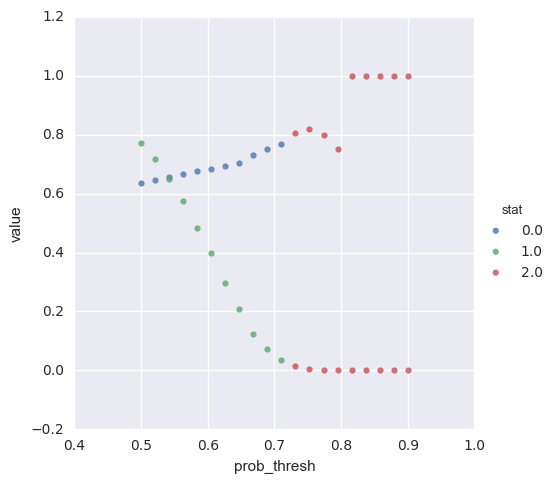

In [510]:
# 500 estimators
print(classification_report(rfc.predict(X_dev_cat), Y_dev))
calibration_matrix = get_calibration(rfc, X_dev_cat, Y_dev)

             precision    recall  f1-score   support

      False       0.34      0.61      0.43      2310
       True       0.85      0.64      0.73      7690

avg / total       0.73      0.63      0.66     10000

Max recall is 0.7477876106194691


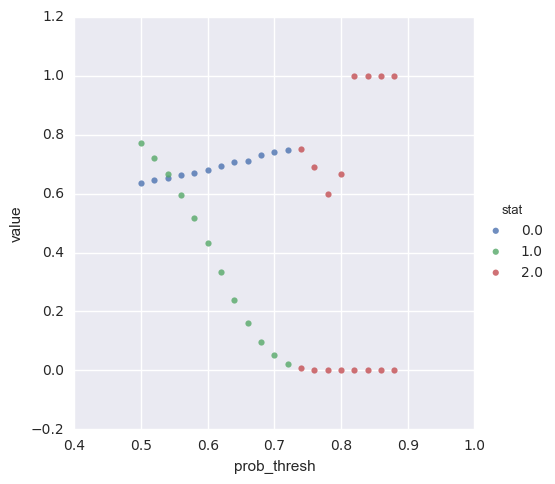

In [480]:
# 500 estimators
print(classification_report(rfc.predict(X_dev_cat), Y_dev))
calibration_matrix = get_calibration(rfc, X_dev_cat, Y_dev)

Max recall is 0.7272727272727273


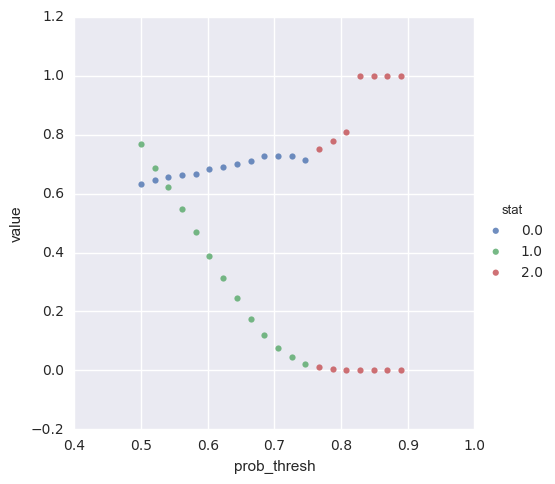

In [481]:
# most important features
# most are from p7 batted balls
pd.DataFrame(np.hstack([np.array(X_train.columns).reshape(195,1), rfc.feature_importances_.reshape(195,1)])).sort_values(by = 1, ascending=False)

,0,1
120,battedballs_p7_|_PA,0.0140444
126,battedballs_p7_|_HR/FB,0.0071101
122,battedballs_p7_|_LD%,0.00696502
167,hand_splits_season_|_K%,0.00680314
125,battedballs_p7_|_IFFB%,0.00663892
127,battedballs_p7_|_IFH%,0.00658805
132,battedballs_p7_|_Soft%,0.00646241
131,battedballs_p7_|_Oppo%,0.00644042
129,battedballs_p7_|_Pull%,0.00642087
130,battedballs_p7_|_Cent%,0.00635317


## Weight individual trees on bootstrapped data

In [45]:
rfc = RandomForestClassifier(n_estimators=500, max_features=7, min_samples_leaf = 10)
rfc.fit(X_train_cat, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [89]:
def calculate_tree_weights(model, train_set, train_labels):
    """Calculate weights for each tree in random forest. 
    Weights based on accuracy of top ten percent of bootstrapped sample"""
    tree_weights = []
    
    # loop through all trees in forest
    for tree in model.estimators_:
        avg_performance =[]
        
        # randomly sample from training set 20 times
        for s in range(20):
            sample = train_set.sample(5000, replace = True)
            coef = tree.predict_proba(sample)
            coef = pd.DataFrame(coef, columns=['no_hit','hit'], index=sample.index)
            coef = pd.merge(coef, pd.DataFrame(train_labels), how = 'left', left_index=True, right_index=True)
            coef = coef.sort_values(by = "hit",ascending=False)
            
            # compute average prediction of x% of sample with highest coefficients based on pandas sort
            top_picks = int(len(sample) * .02)
            performance = coef[:top_picks].mean()[2]
            avg_performance.append(performance)
        avg_performance = np.mean(np.array(avg_performance))
        tree_weights.append(avg_performance)
    return tree_weights
tw = calculate_tree_weights(rfc, X_train_cat, Y_train)
tw = np.array(tw) * 100

[0.877,
 0.85899999999999999,
 0.87349999999999994,
 0.85799999999999998,
 0.8620000000000001,
 0.87799999999999989,
 0.87100000000000011,
 0.86799999999999999,
 0.86950000000000005,
 0.87850000000000006,
 0.87850000000000006,
 0.86649999999999994,
 0.87149999999999994,
 0.86750000000000005,
 0.85999999999999999,
 0.84949999999999992,
 0.86250000000000004,
 0.85699999999999998,
 0.86699999999999999,
 0.85999999999999999,
 0.85399999999999987,
 0.87850000000000006,
 0.85699999999999998,
 0.86850000000000005,
 0.86850000000000005,
 0.88200000000000001,
 0.87949999999999995,
 0.88149999999999995,
 0.85749999999999993,
 0.86449999999999994,
 0.86999999999999988,
 0.85599999999999987,
 0.8630000000000001,
 0.87149999999999994,
 0.88249999999999995,
 0.88049999999999995,
 0.86950000000000005,
 0.85549999999999993,
 0.86299999999999988,
 0.86449999999999994,
 0.8640000000000001,
 0.8859999999999999,
 0.87050000000000005,
 0.86949999999999983,
 0.87399999999999989,
 0.86049999999999982,
 0.872

In [105]:
# no weights
for i, tree in enumerate(rfc.estimators_):
    pred = tree.predict(X_dev_cat)
    pred = pred.reshape(10000,1)
    if i == 0:
        pred_matrix = pred
    else:
        pred_matrix = np.hstack([pred_matrix,pred])

In [148]:
np.median(tw)

86.724999999999994

In [149]:
np.percentile(tw, 50)

86.724999999999994

In [150]:
# with weights. only from 20% percentage of trees
first_time = 0
for tree, weight in zip(rfc.estimators_, tw):
    if weight < np.percentile(tw, 80):
        continue
    pred = tree.predict(X_dev_cat)
    pred = pred.reshape(10000,1)
    if first_time == 0:
        pred_matrix = pred
    else:
        pred_matrix = np.hstack([pred_matrix,pred])
    first_time = 1

tree_vote2 = np.mean(pred_matrix, axis = 1)

In [151]:
pred_matrix.shape

(10000, 103)

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


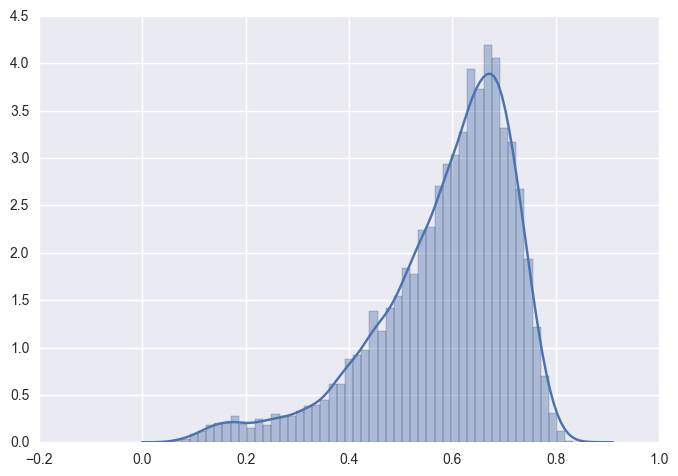

In [112]:
tree_vote1 = np.mean(pred_matrix, axis = 1)
sns.distplot(tree_vote1)

Max recall is 0.7427745664739884


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


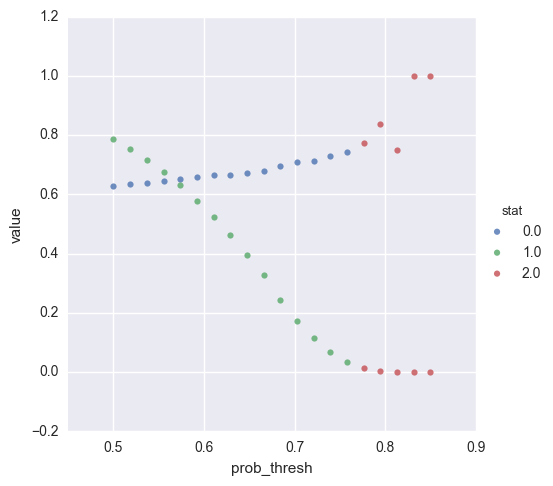

In [124]:
calibration_matrix = get_calibration(labels=Y_dev, tree_vote = tree_vote1)

Max recall is 0.7398648648648649


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


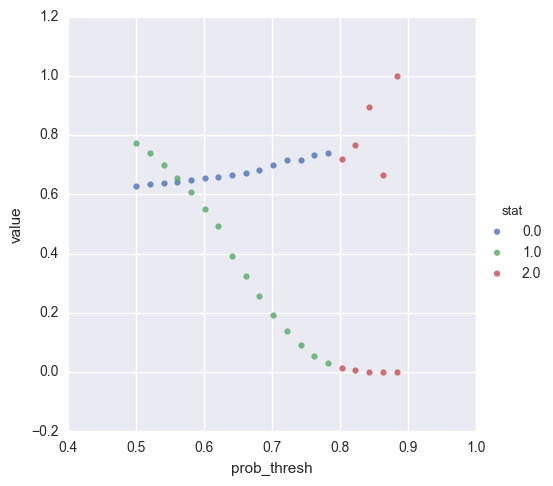

In [153]:
calibration_matrix = get_calibration(labels=Y_dev, tree_vote = tree_vote2)

Max recall is 0.7451737451737451


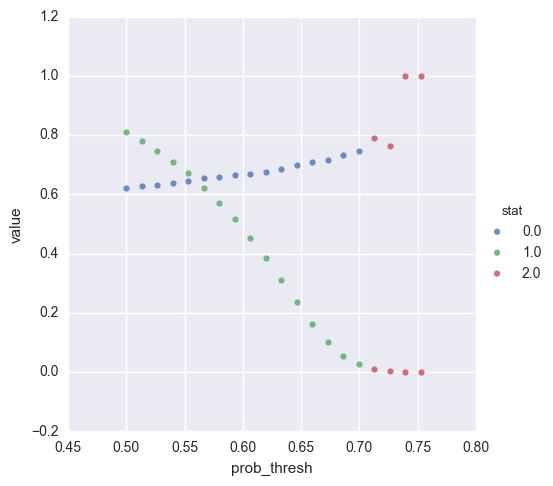

In [125]:
calibration_matrix = get_calibration(labels = Y_dev, model=rfc, df = X_dev_cat)

In [23]:
X_train_cat.sample(5000, replace=True)

,opp_team_bullpen_p7_|_IP,opp_team_bullpen_p7_|_TBF,opp_team_bullpen_p7_|_K/9,opp_team_bullpen_p7_|_BB/9,opp_team_bullpen_p7_|_K/BB,opp_team_bullpen_p7_|_HR/9,opp_team_bullpen_p7_|_K%,opp_team_bullpen_p7_|_BB%,opp_team_bullpen_p7_|_K-BB%,opp_team_bullpen_p7_|_AVG,...,ah_splits_season_|_SLG,ah_splits_season_|_OPS,ah_splits_season_|_ISO,ah_splits_season_|_BABIP,ah_splits_season_|_wRC,ah_splits_season_|_wRAA,ah_splits_season_|_wOBA,ah_splits_season_|_wRC+,is_weekend,week_num
21255,0,0,4,0,4,3,4,0,4,0,...,1,2,1,2,1,2,3,3,True,1
95234,1,2,0,0,2,4,0,0,0,4,...,4,4,4,4,3,4,4,4,False,4
41876,0,0,2,1,3,1,3,1,3,2,...,1,0,1,3,2,0,0,0,False,3
48588,3,4,1,2,1,1,1,2,1,4,...,2,3,1,4,4,4,3,1,False,4
21480,0,0,3,0,4,1,3,0,4,2,...,1,1,1,2,2,0,1,1,True,1
121317,1,1,3,0,4,2,3,0,3,2,...,1,1,1,3,2,0,1,1,True,1
89464,3,3,4,1,4,3,4,1,4,1,...,4,3,4,2,4,4,3,3,False,3
26845,2,2,1,0,3,0,1,0,2,2,...,1,1,1,2,1,1,1,1,False,2
30723,0,0,0,0,3,2,0,0,1,0,...,4,4,4,3,4,4,4,4,True,2
133943,2,1,0,3,1,3,1,3,1,0,...,0,0,1,0,1,0,0,0,True,2
